# Load data

In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [9]:
#### Load true and false flares data
# Load dataframes
true_flares_df_raw = pd.read_csv('../Chandra_data/trueflares.csv')
false_flares_df_raw = pd.read_csv('../Chandra_data/falseflares.csv')
true_flares_df = true_flares_df_raw[['time','energy','obsreg_id']]
false_flares_df = false_flares_df_raw[['time','energy','obsreg_id']]
starting_times = pd.read_csv('../Chandra_data/starting_time.csv')

# Convert to data dictionary
d = true_flares_df.groupby('obsreg_id').apply(lambda group: (1,np.array(group[['time', 'energy']]))).to_dict()
d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: (0,np.array(group[['time', 'energy']]))).to_dict())

In [10]:
# Prepare for data, drop the outliers
data_lst = []
raw_data_lst = []
lengths = []
lengths_true = []
Ts_true = []
Ts = []
lengths_false = []
Ts_false = []
length_threshold = 5000
T_threshold = 250000
T_threshold_low = 43200
t_scale = 5000
num_flares = 436
i_flare = 0

for key in list(d.keys()):
    event_class = d[key][0]
    event_list = d[key][1]
    event_list[:,0] = event_list[:,0] - min(event_list[:,0])
    T = max(event_list[:,0]) - min(event_list[:,0])
    # Drop too short ones
    
    if T < T_threshold_low:
        continue
    else:
        raw_data_lst.append({'class':event_class,'event_list':event_list})
        # Only select windows of 43200
        if i_flare < num_flares:
            temp_t = starting_times['t'][i_flare] * 1000
            if temp_t > T - T_threshold_low:
                temp_t = T - T_threshold_low
            i_flare += 1
        else:
            temp_t = 0
        event_list = event_list[(event_list[:,0] >= temp_t) & (event_list[:,0] <= temp_t + T_threshold_low),:]
        event_list[:,0] = event_list[:,0] - temp_t
        T = max(event_list[:,0])
        length = len(event_list)
        lengths.append(length)
        Ts.append(T)
        if event_class == 1:
            lengths_true.append(length)
            Ts_true.append(T)
        else:
            lengths_false.append(length)
            Ts_false.append(T)
        data_lst.append({'class':event_class,'event_list':event_list})
            
lengths = np.array(lengths)
Ts = np.array(Ts)
lengths_true = np.array(lengths_true)
Ts_true = np.array(Ts_true)
lengths_false = np.array(lengths_false)
Ts_false = np.array(Ts_false)

In [11]:
# Visualize distribution of T and lengths
# fig, ax = plt.subplots(1,2)
# ax[0].hist(lengths_true,bins=20);
# ax[0].set_title('Event list lengths')

# ax[1].hist(Ts_true,bins=20);
# ax[1].set_title('Event list time range')
# plt.tight_layout()

In [12]:
# Visualize 16 flares/non_flares
# def visualize_hist(times, t_scale):
#     times = times / t_scale
#     plt.hist(times, bins = np.arange(np.ceil(max(times))))

# plt.figure(figsize=(12,7))
# start_index = 16
# for i in range(16):
#     index = start_index + i
#     plt.subplot(4,4,i+1)
#     plt.title(index)
#     visualize_hist(data_lst[index]['event_list'][:,0],500)
# plt.tight_layout()
# plt.show()

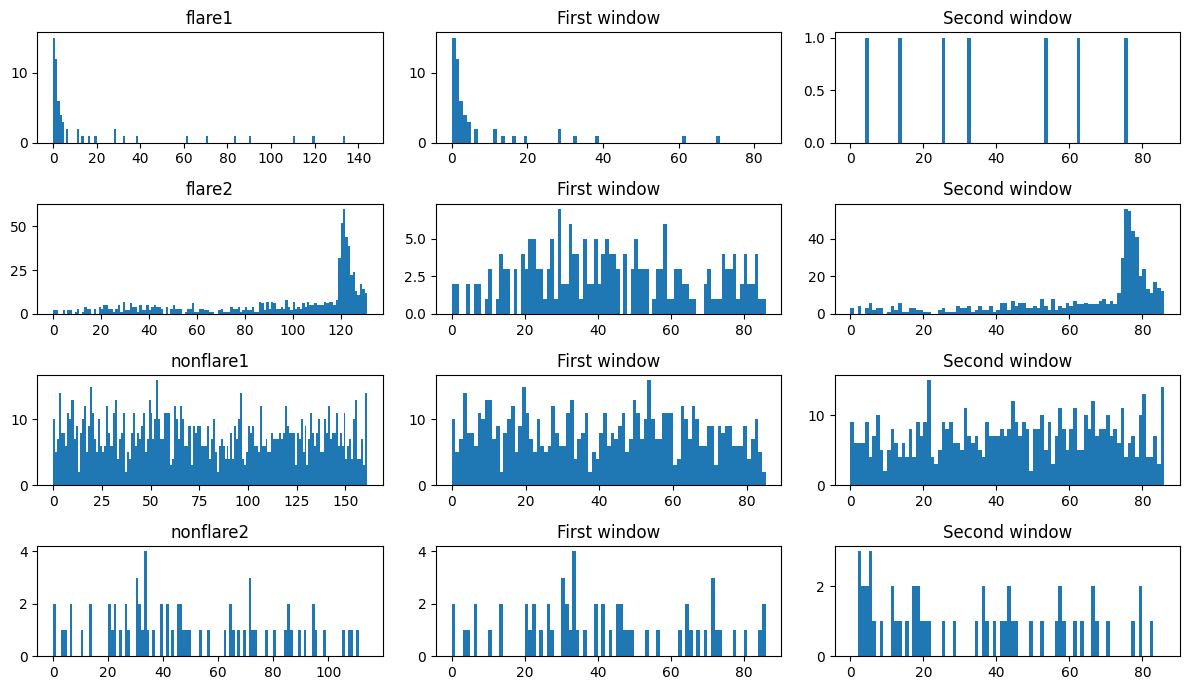

In [13]:
# Select some moving windows
def visualize_hist(times, t_scale):
    times = times / t_scale
    plt.hist(times, bins = np.arange(np.ceil(max(times))))

############ Find which eventfiles are worth visualizing
# plt.figure(figsize=(12,7))
# i = 0
# for key in list(d.keys()):
#     event_class = d[key][0]
#     event_list = d[key][1]
#     event_list[:,0] = event_list[:,0] - min(event_list[:,0])
#     T = max(event_list[:,0]) - min(event_list[:,0])
#     # Drop too short ones
#     if T < T_threshold_low:
#         continue
#     else:
#         if i > 600:
#             plt.subplot(4,4,i-600)
#             plt.title(i)
#             visualize_hist(event_list[:,0],500)
#         i += 1
#         if i == 600+16:
#             break
# plt.tight_layout()
# plt.show()  
    
########## Record them
special_visualizing_indices = [[6,0,50], [7,0,100], [502,0,50], [515,0,200]]
titles = ['flare1','flare2','nonflare1','nonflare2']
N = 729
T_threshold_low = 43200

########## Make visualizing plots
plt.figure(figsize=(12,7))
for i in range(4):
    temp_inds = special_visualizing_indices[i]
    
    # Visualize the whole thing
    event_list = raw_data_lst[temp_inds[0]]['event_list']
    T = np.max(event_list[:,0])
    plt.subplot(4,3,i*3+1)
    visualize_hist(event_list[:,0],500)
    plt.title(titles[i])
    
    # Viauslize the first half
    temp_t = temp_inds[1] * 1000
    first_list = event_list[(event_list[:,0] >= temp_t) & (event_list[:,0] <= temp_t + T_threshold_low),:]
    first_list[:,0] = first_list[:,0] - temp_t
    plt.subplot(4,3,i*3+2)
    visualize_hist(first_list[:,0],500)
    plt.title('First window')
    data_lst.append({'class':2,'event_list':first_list})
    
    # Viauslize the second half
    temp_t = temp_inds[2] * 1000
    if temp_t > T - T_threshold_low:
        temp_t = T - T_threshold_low
    second_list = event_list[(event_list[:,0] >= temp_t) & (event_list[:,0] <= temp_t + T_threshold_low),:]
    second_list[:,0] = second_list[:,0] - temp_t
    plt.subplot(4,3,i*3+3)
    visualize_hist(second_list[:,0],500)
    plt.title('Second window')
    data_lst.append({'class':2,'event_list':second_list})
plt.tight_layout()
plt.show() 

In [14]:
# Record special labels
B = 16
data = RealEventsDataset(data_lst,E_bins=13,t_scale=t_scale)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)

In [15]:
# Create and save NN model
num_freqs = 12
num_latent = 30
E_bins = 13
encoding = PositionalEncoding(num_freqs=num_freqs)
model = AutoEncoder('lstm', num_latent, encoding, hidden_size=512, E_bins=E_bins, lam_TV=0.2, lam_latent=0,
                        d_encoder_model=48, nhead=4, dim_feedforward=512)
model.load_state_dict(torch.load('../experiments/lstm_800epochs_lamTV02_B16_lr1e-3_tol200_samelength/model.pth'));
model.to(device);

In [16]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)
outputs = []
for idx, batch in enumerate(test_loader):
    batch = todevice(batch, device)
    outputs.append(todevice(model(batch),'cpu'))

def output_collate_fn(outputs):
    '''
    Outputs is a list of dic
    '''
    output = {}
    for key in outputs[0].keys():
        if key in ['latent','T','num_events','class']:
            output[key] = torch.cat([o[key] for o in outputs], dim=0)
        # elif key == 'class':
        #     output[key] = sum([o[key] for o in outputs],[])
        else:
            output[key] = [o[key] for o in outputs]
    return output

collated_outputs = output_collate_fn(outputs)
collated_outputs['num_events_per'] = collated_outputs['num_events'] / collated_outputs['T']

# PCA

## Moving windows for some eventfiles

Text(0.5, 1.0, 'PCA of latent representations')

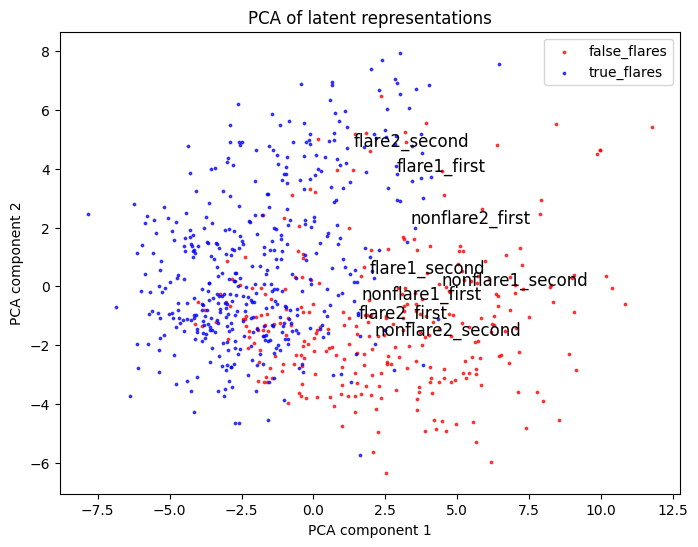

In [20]:
metric = 'class'

# Continuous metric
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z = collated_outputs['latent']
embedding = pca.fit_transform(z)

# Define binary color map
colors = ['red', 'blue']  # Choose colors that suit your preference
labels = ['false_flares', 'true_flares']  # Replace with meaningful group names

plt.figure(figsize=(8, 6))
for group in [0, 1]:
    idx = (collated_outputs[metric] == group)
    plt.scatter(embedding[idx, 0], embedding[idx, 1], c=colors[group], label=labels[group], 
                alpha=0.7, marker='o', s=3)
    
N = 729
special_labels = ['flare1_first','flare1_second',
                 'flare2_first','flare2_second',
                 'nonflare1_first','nonflare1_second',
                 'nonflare2_first','nonflare2_second']
for i, l in enumerate(special_labels):
    x, y = embedding[i+N, :]
    plt.annotate(l, (x, y), textcoords="offset points", xytext=(0,0), ha='center',color='black', fontsize=12)
    
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
# plt.savefig(f'../plots/PCA_{metric}.png')







Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 737
Input similarities computed in 0.12 seconds (sparsity = 0.181080)!
Learning embedding...
Iteration 50: error is 65.172150 (50 iterations in 0.89 seconds)
Iteration 100: error is 65.172151 (50 iterations in 1.66 seconds)
Iteration 150: error is 65.172103 (50 iterations in 1.22 seconds)
Iteration 200: error is 65.171770 (50 iterations in 0.72 seconds)
Iteration 250: error is 2.945873 (50 iterations in 0.28 seconds)
Iteration 300: error is 1.404706 (50 iterations in 0.29 seconds)
Iteration 350: error is 1.298166 (50 iterations in 0.27 seconds)
Iteration 400: error is 1.274209 (50 iterations in 0.27 seconds)
Iteration 450: error is 1.265865 (50 iterations in 0.27 seconds)
Iteration 500: error is 1.260276 (50 iterations in 0.27 seconds)
Iteration 550: error is 1.256574 (50 iterations in 0.27 seconds)
Iteration 600: error is 1

Text(0.5, 1.0, 'tSNE of latent representations')

Iteration 999: error is 1.244036 (50 iterations in 0.27 seconds)
Fitting performed in 8.83 seconds.


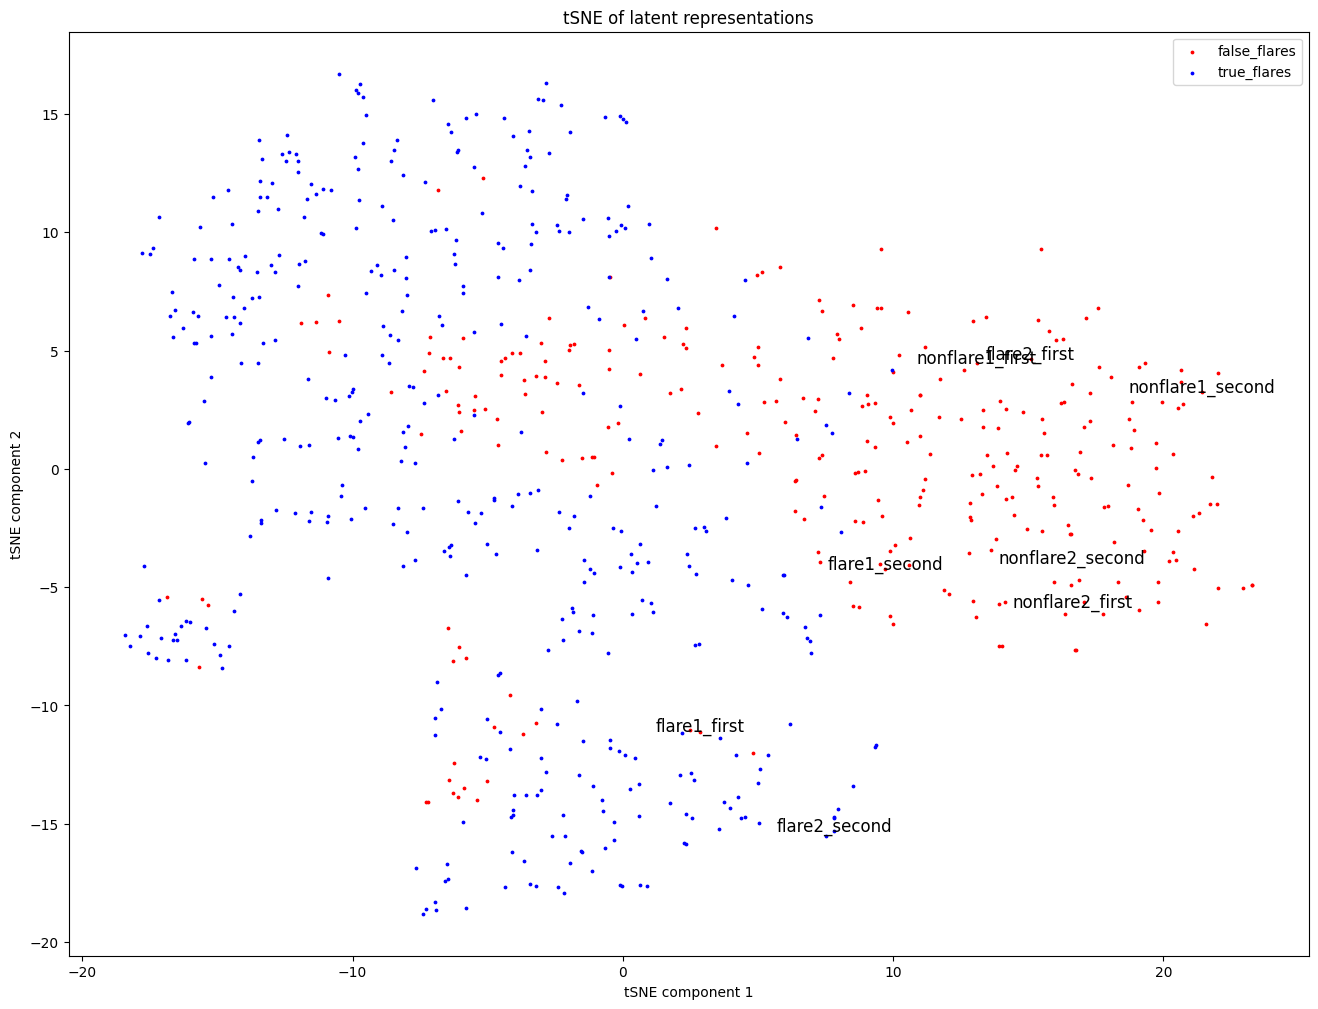

In [24]:
from bhtsne import tsne
data_nd_tsne = tsne(z.numpy().astype(np.float64))

labels = collated_outputs['class'].numpy()

colors = ['red', 'blue']  # Choose colors that suit your preference
names = ['false_flares', 'true_flares']  # Replace with meaningful group names

plt.figure(figsize=(16, 12))
for group in [0,1]:
    idx = labels == group
    plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[group], label=names[group], marker='o',s=3)
    
N = 729
special_labels = ['flare1_first','flare1_second',
                 'flare2_first','flare2_second',
                 'nonflare1_first','nonflare1_second',
                 'nonflare2_first','nonflare2_second']
for i, l in enumerate(special_labels):
    x, y = data_nd_tsne[i+N, :]
    plt.annotate(l, (x, y), textcoords="offset points", xytext=(0,0), ha='center',color='black', fontsize=12)
    
plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.legend(loc='best')
plt.title('tSNE of latent representations')
# plt.savefig(f'../plots/tSNE_same.png')

## Cut some eventfiles in half

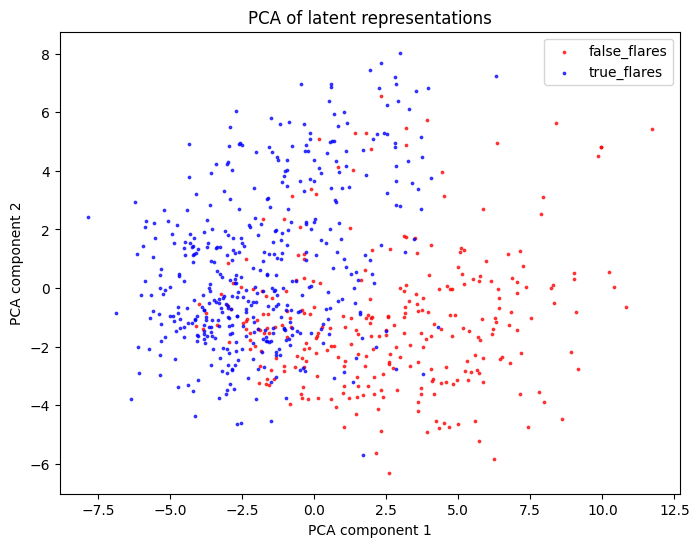

In [27]:
metric = 'class'

# Continuous metric
##### PCA
from sklearn.decomposition import PCA



# pca = PCA(n_components=2)
# z = collated_outputs['latent']
# embedding = pca.fit_transform(z)

# plt.figure(figsize=(16,12))
# scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
#             marker='o',s=3, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
# plt.colorbar(scatter, label=metric)

# special_labels = {'late_flare_1':22,
#                  'late_flare_2':20,
#                   'early_flare_1':16,
#                   'early_flare_2':19,
#                  'no_flare_1':612,
#                  'no_flare_2':614,
#                  'late_flare_1_half':22+N,
#                  'late_flare_2_half':20+N,
#                   'early_flare_1_half':16+N,
#                   'early_flare_2_half':19+N,
#                  'no_flare_1_half':612+N,
#                  'no_flare_2_half':614+N,}
# for k, v in special_labels.items():
#     x, y = embedding[v, :]  # 15th point (indexing starts from 0)
#     plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,0), ha='center',color='red', fontsize=12)

# plt.xlabel('PCA component 1')
# plt.ylabel('PCA component 2')
# plt.legend(loc='best')
# plt.title('PCA of latent representations')
# # plt.savefig(f'../plots/PCA_{metric}.png')


pca = PCA(n_components=2)
z = collated_outputs['latent']
embedding = pca.fit_transform(z)

# Define binary color map
colors = ['red', 'blue']  # Choose colors that suit your preference
labels = ['false_flares', 'true_flares']  # Replace with meaningful group names

plt.figure(figsize=(8, 6))
for group in [0, 1]:
    idx = (collated_outputs[metric] == group)
    plt.scatter(embedding[idx, 0], embedding[idx, 1], c=colors[group], label=labels[group], 
                alpha=0.7, marker='o', s=3)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
plt.savefig(f'../plots/PCA_same_{metric}.png')

## t-SNE

Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 729
Input similarities computed in 0.12 seconds (sparsity = 0.182675)!
Learning embedding...
Iteration 50: error is 65.062908 (50 iterations in 0.63 seconds)
Iteration 100: error is 65.063383 (50 iterations in 0.52 seconds)
Iteration 150: error is 65.062261 (50 iterations in 0.52 seconds)
Iteration 200: error is 65.062519 (50 iterations in 0.48 seconds)
Iteration 250: error is 2.937114 (50 iterations in 0.47 seconds)
Iteration 300: error is 1.381943 (50 iterations in 0.32 seconds)
Iteration 350: error is 1.292667 (50 iterations in 0.24 seconds)
Iteration 400: error is 1.265977 (50 iterations in 0.24 seconds)
Iteration 450: error is 1.252544 (50 iterations in 0.24 seconds)
Iteration 500: error is 1.243889 (50 iterations in 0.24 seconds)
Iteration 550: error is 1.237515 (50 iterations in 0.23 seconds)
Iteration 600: error is 1

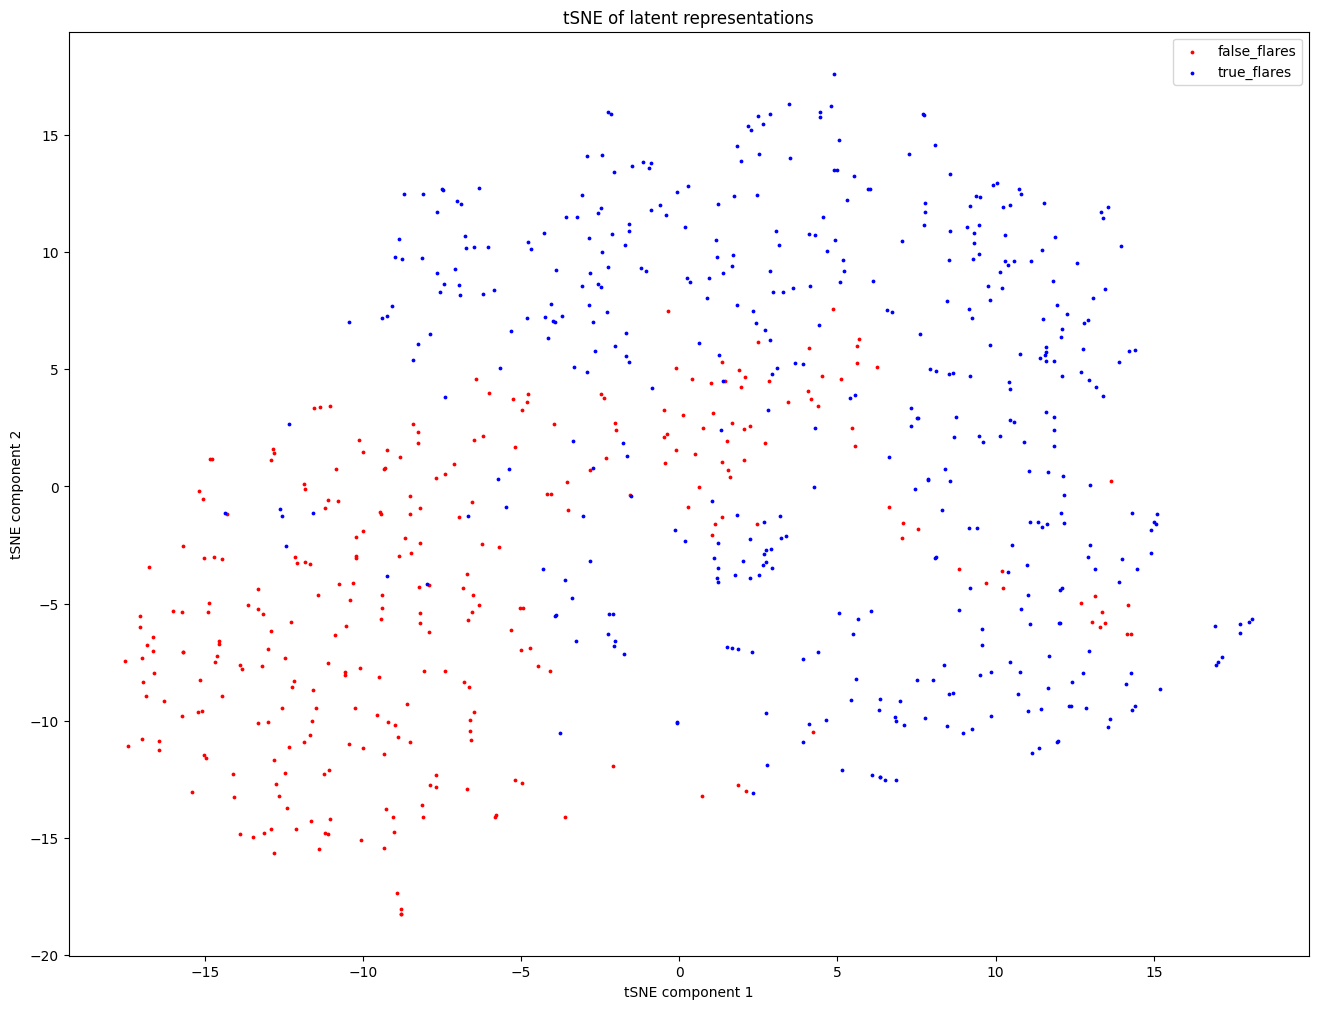

In [26]:
from bhtsne import tsne
data_nd_tsne = tsne(z.numpy().astype(np.float64))

labels = collated_outputs['class'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

colors = ['red', 'blue']  # Choose colors that suit your preference
names = ['false_flares', 'true_flares']  # Replace with meaningful group names

plt.figure(figsize=(16, 12))
for group in [0,1]:
    idx = labels == group
    plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[group], label=names[group], marker='o',s=3)

plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.legend(loc='best')
plt.title('tSNE of latent representations')
plt.savefig(f'../plots/tSNE_same.png')

# from bhtsne import tsne
# data_nd_tsne = tsne(z.numpy().astype(np.float64))

# plt.figure(figsize=(16, 12))
# plt.scatter(data_nd_tsne[:, 0], data_nd_tsne[:, 1], marker='o',s=3)

# for k, v in special_labels.items():
#     x, y = data_nd_tsne[v, :]  # 15th point (indexing starts from 0)
#     plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,0), ha='center')

# plt.xlabel('tSNE component 1')
# plt.ylabel('tSNE component 2')
# plt.legend(loc='best')
# plt.title('tSNE of latent representations')
# plt.savefig(f'../plots/tSNE.png')




## Single dimension visualization

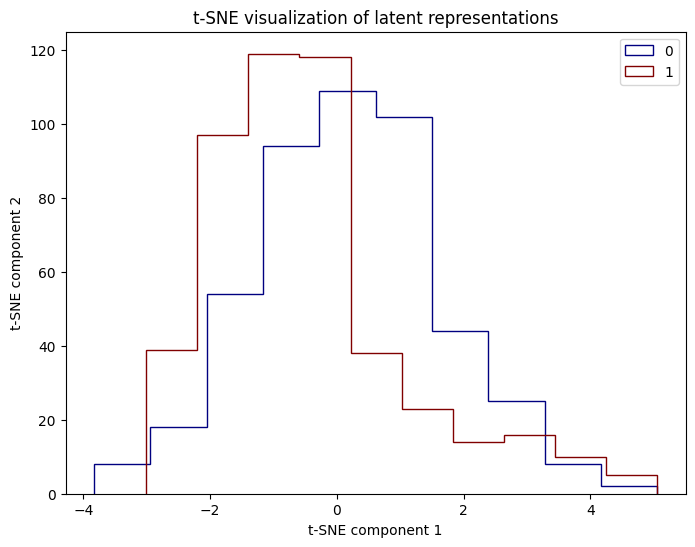

In [67]:
labels = collated_outputs['class'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 1], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

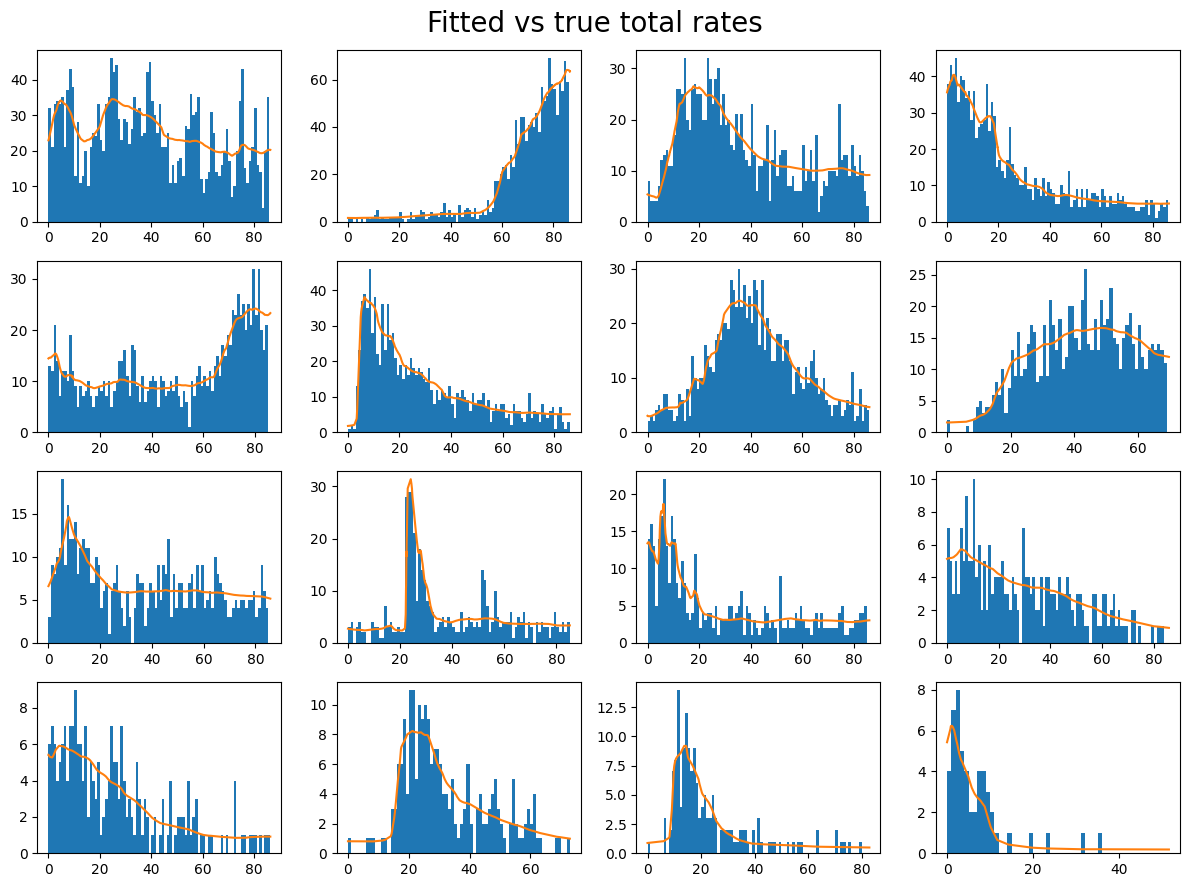

In [30]:
plotting_t_scale = 10

# Plot total rates
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, torch.sum(rates,dim=-1))
    # plt.xlabel('t (rescaled for better visualization)')
    # plt.ylabel('rate')
plt.suptitle('Fitted vs true total rates',size=20)
plt.tight_layout()
plt.savefig('../plots/total_rate_comparison_same.png')
plt.show()




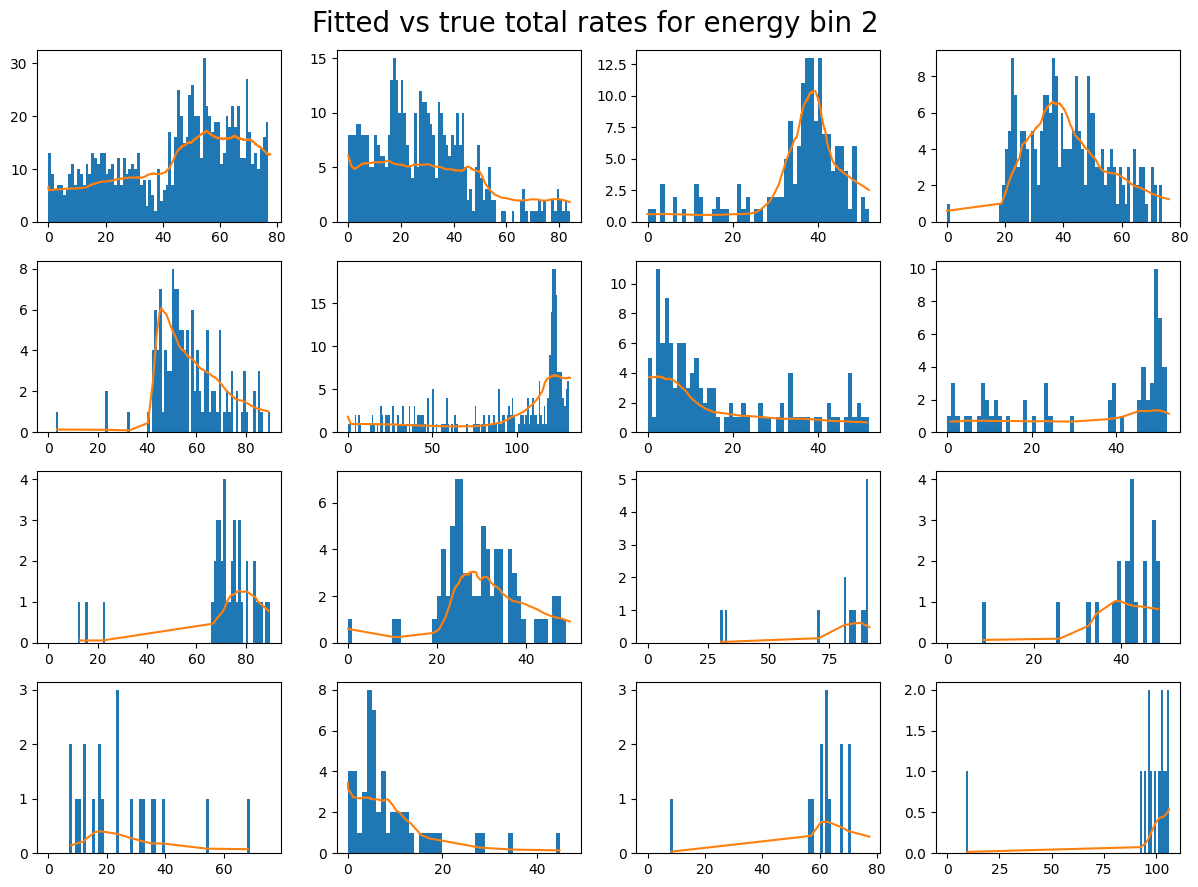

In [23]:
# Plot rates for a specific energy bin
plt.figure(figsize=(12,9))
batch_index = 1
start_index = 0
E_index = 1
for i in range(16):
    index = start_index + i
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,:]
    E_mask = times[:,E_index+1]==1
    times = times[E_mask,0] * plotting_t_scale
    rates = batch['rates'][index,mask,E_index]
    rates = rates[E_mask] / plotting_t_scale
    T = batch['T'][index] * plotting_t_scale
    
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, rates)
plt.suptitle(f'Fitted vs true total rates for energy bin {E_index+1}',size=20)
plt.tight_layout()
plt.savefig(f'../plots/total_rate_comparison_E{E_index+1}.png')
plt.show()

In [32]:
import pickle
with open(f'../Chandra_data/small_eventfiles_lifetime43200.pkl', 'rb') as file: 
    data_lst = pickle.load(file)
data = RealEventsDataset(data_lst,t_scale=5000)
encoding = PositionalEncoding(num_freqs=12)
model = AutoEncoder.load_from_checkpoint(f'../experiments/small_lstm_lamTV02_B16_lr1e-3/model_400epochs.ckpt',
                                          model_type='lstm', latent_size=30, encoding=encoding,
                                          hidden_size=512, E_bins=14, lam_TV=0.2, 
                                           lam_latent=0, d_encoder_model=48,
                                           nhead=4,num_encoder_layers=1,
                                           dim_feedforward=512, lr=0.01)

In [33]:
model.to(device)
B_test = 16
test_loader = DataLoader(data, batch_size=B_test, collate_fn=padding_collate_fn)
outputs = []
for idx, batch in enumerate(test_loader):
    batch = todevice(batch, device)
    outputs.append(todevice(model(batch),'cpu'))

In [51]:
iterr = iter(test_loader)
_ = next(iterr)
batch = next(iterr)

In [62]:
batch = todevice(batch, device)
# code t_list
event_t_list = batch['event_list']
coded_event_t_list = model.code(event_t_list) # (B, n, code_size+E_bins)
B, n, _ = coded_event_t_list.shape

# encode
T, _ = torch.max(event_t_list[:,:,0], dim=1)
model.encode(coded_event_t_list, batch['event_list_len'])

# decode, for both the event list and a mesh (for integration)
coded_mesh_t_list = model.code((T.unsqueeze(-1) * torch.linspace(0, 1, model.resolution+1).to(coded_event_t_list.device).unsqueeze(0)).unsqueeze(-1))
indices = batch['idx']
log_event_rate_list = model.decode(coded_event_t_list[:,:,:model.code_size], indices) # (B, n, E_bins)
log_mesh_rate_list = model.decode(coded_mesh_t_list, indices) # (B, n, E_bins)

# Compute the loss
# loss = -loglikelihood(log_event_rate_list, batch['mask'], event_t_list[:,:,-model.E_bins:], log_mesh_rate_list, T) 
B, n_mesh, E_bins = log_mesh_rate_list.shape
T_mask = batch['mask']
E_mask = event_t_list[:,:,-model.E_bins:]
integral = 0.5 * (torch.sum(torch.exp(log_mesh_rate_list[:,1:,:]), dim=(1,2)) + torch.sum(torch.exp(log_mesh_rate_list[:,:-1,:]), dim=(1,2))) * T / (n_mesh-1)   # (B,)
pos =  torch.sum(log_event_rate_list * T_mask.unsqueeze(-1) * E_mask, dim=(1,2))

# if model.lam_TV > 0:
    # loss += self.lam_TV * loss_TV(log_event_rate_list)
    # loss += model.lam_TV * loss_TV(log_mesh_rate_list)
print(pos)
print(integral)
print(torch.mean(pos - integral))

tensor([3163.6072, 1440.3130, 1888.4138, 1386.3091, 1672.1705, 1998.1462,
        1748.9087,  932.2280,  881.9594, 1009.8193,  676.5632,  260.3543,
         306.9378,  292.2357,  199.2789,   68.2214], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([605.8824, 605.9697, 604.2418, 605.1964, 602.5594, 604.1051, 603.3781,
        488.7507, 601.3315, 597.1439, 603.0593, 601.6953, 605.1966, 512.1218,
        581.2799, 361.1641], device='cuda:0', grad_fn=<DivBackward0>)
tensor(546.3994, device='cuda:0', grad_fn=<MeanBackward0>)


In [64]:
model.lam_TV

0.2

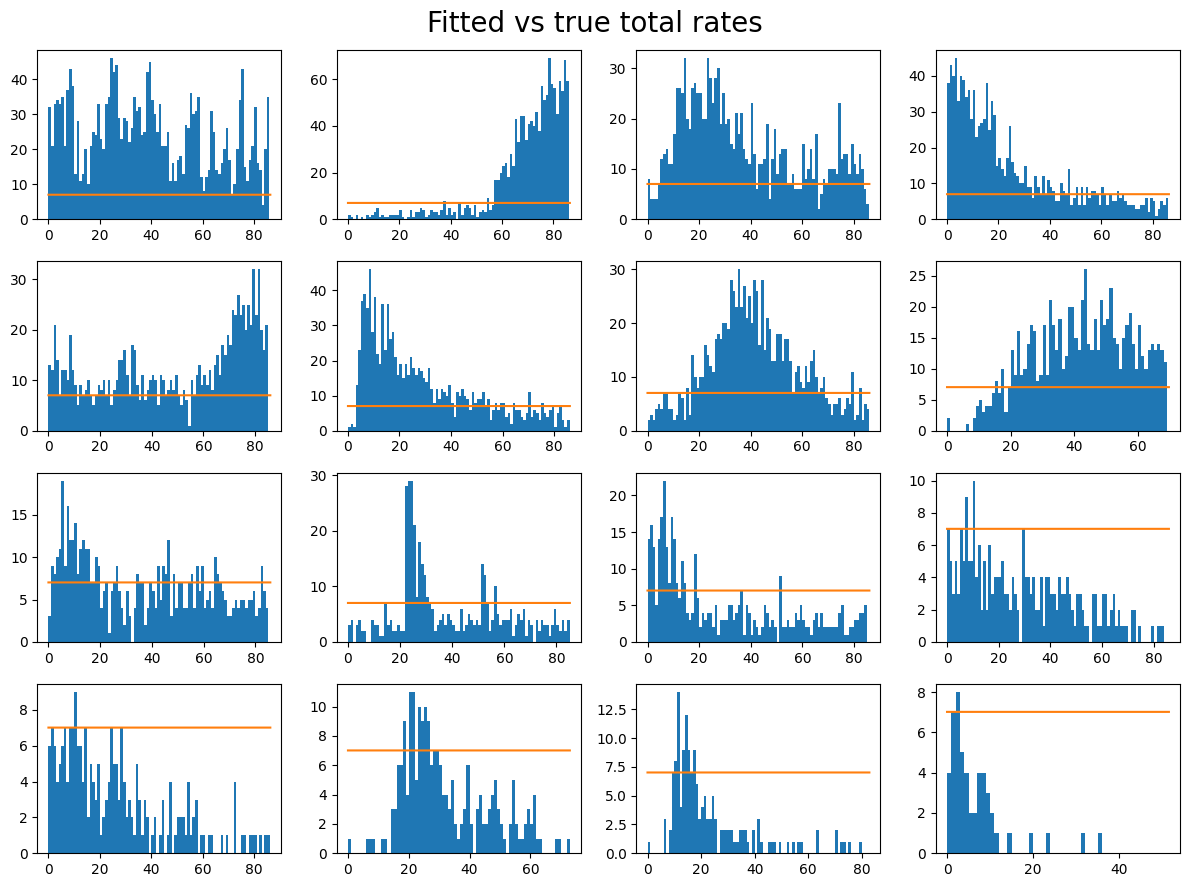

In [37]:
# Plot total rates
plotting_inds = [i for i in range(16,32)]

plt.figure(figsize=(12,9))
for i, total_index in enumerate(plotting_inds):
    batch_index = total_index // B_test
    index = total_index % B_test
    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,0] * 10
    rates = batch['rates'][index,mask] / 10
    T = batch['T'][index] * 10
    plt.subplot(4,4,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(T)))
    plt.plot(times, torch.sum(rates,dim=-1))
plt.suptitle('Fitted vs true total rates',size=20)
plt.tight_layout()

In [41]:
rates

tensor([[0.5387, 1.3060, 1.3664, 0.9972, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9971, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9972, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9972, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9971, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3060, 1.3664, 0.9972, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9971, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
         0.2037, 0.1505, 0.1063, 0.0836, 0.0778],
        [0.5387, 1.3059, 1.3664, 0.9972, 0.5976, 0.5086, 0.4470, 0.3568, 0.2747,
  